# Airline customer value analysis case


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

numpy version :  1.21.6
pandas version :  1.3.5
seaborn version :  0.11.2


In [2]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

# Data Collection

In [46]:
data = pd.read_csv('flight.csv', encoding = 'utf-8')
data.head()

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,54993,11/2/2006,12/24/2008,Male,6,.,beijing,CN,31.0,3/31/2014,...,234188.0,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50
1,28065,2/19/2007,8/3/2007,Male,6,NaN,beijing,CN,42.0,3/31/2014,...,167434.0,293678,3/25/2014,7,5.194245,17,29,1.252314,415768,33
2,55106,2/1/2007,8/30/2007,Male,6,.,beijing,CN,40.0,3/31/2014,...,164982.0,283712,3/21/2014,11,5.298507,18,20,1.254676,406361,26
3,21189,8/22/2008,8/23/2008,Male,5,Los Angeles,CA,US,64.0,3/31/2014,...,125500.0,281336,12/26/2013,97,27.863636,73,11,1.090870,372204,12
4,39546,4/10/2009,4/15/2009,Male,6,guiyang,guizhou,CN,48.0,3/31/2014,...,130702.0,309928,3/27/2014,5,4.788079,47,27,0.970658,338813,39


# Data Understanding

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MEMBER_NO          62988 non-null  int64  
 1   FFP_DATE           62988 non-null  object 
 2   FIRST_FLIGHT_DATE  62988 non-null  object 
 3   GENDER             62985 non-null  object 
 4   FFP_TIER           62988 non-null  int64  
 5   WORK_CITY          60719 non-null  object 
 6   WORK_PROVINCE      59740 non-null  object 
 7   WORK_COUNTRY       62962 non-null  object 
 8   AGE                62568 non-null  float64
 9   LOAD_TIME          62988 non-null  object 
 10  FLIGHT_COUNT       62988 non-null  int64  
 11  BP_SUM             62988 non-null  int64  
 12  SUM_YR_1           62437 non-null  float64
 13  SUM_YR_2           62850 non-null  float64
 14  SEG_KM_SUM         62988 non-null  int64  
 15  LAST_FLIGHT_DATE   62988 non-null  object 
 16  LAST_TO_END        629

In [48]:
data.shape

(62988, 23)

There are 62988 rows of data with 23 features which do not have targets/outputs/labels, so in this segmentation case we will use Machine Learning Unsupervised - Clustering.

In [49]:
data.dtypes

MEMBER_NO              int64
FFP_DATE              object
FIRST_FLIGHT_DATE     object
GENDER                object
FFP_TIER               int64
WORK_CITY             object
WORK_PROVINCE         object
WORK_COUNTRY          object
AGE                  float64
LOAD_TIME             object
FLIGHT_COUNT           int64
BP_SUM                 int64
SUM_YR_1             float64
SUM_YR_2             float64
SEG_KM_SUM             int64
LAST_FLIGHT_DATE      object
LAST_TO_END            int64
AVG_INTERVAL         float64
MAX_INTERVAL           int64
EXCHANGE_COUNT         int64
avg_discount         float64
Points_Sum             int64
Point_NotFlight        int64
dtype: object

In [50]:
# renaming 'avg_discount'
data = data.rename(columns={'avg_discount': 'AVG_DISCOUNT'})

# Data Preprocessing

## Check Null and Missing Values

In [59]:
# The fare is not empty but reserved# Only keep records where the fare is non-zero, or the average discount rate and total flight kilometers are both 0.
clean = data[data['SUM_YR_1'].notnull() & data['SUM_YR_2'].notnull()] 

# Only keep records where the fare is non-zero, or the average discount rate and total flight kilometers are both 0.
index1 = clean['SUM_YR_1'] != 0
index2 = clean['SUM_YR_2'] != 0
index3 = (data['SEG_KM_SUM'] == 0) & (data['AVG_DISCOUNT'] == 0)
clean = clean[index1 | index2 | index3] 

In [60]:
clean

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,AVG_DISCOUNT,Points_Sum,Point_NotFlight
0,54993,11/2/2006,12/24/2008,Male,6,.,beijing,CN,31.0,3/31/2014,...,234188.0,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50
1,28065,2/19/2007,8/3/2007,Male,6,NaN,beijing,CN,42.0,3/31/2014,...,167434.0,293678,3/25/2014,7,5.194245,17,29,1.252314,415768,33
2,55106,2/1/2007,8/30/2007,Male,6,.,beijing,CN,40.0,3/31/2014,...,164982.0,283712,3/21/2014,11,5.298507,18,20,1.254676,406361,26
3,21189,8/22/2008,8/23/2008,Male,5,Los Angeles,CA,US,64.0,3/31/2014,...,125500.0,281336,12/26/2013,97,27.863636,73,11,1.090870,372204,12
4,39546,4/10/2009,4/15/2009,Male,6,guiyang,guizhou,CN,48.0,3/31/2014,...,130702.0,309928,3/27/2014,5,4.788079,47,27,0.970658,338813,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62974,11163,5/8/2005,8/26/2005,Male,4,NaN,NaN,CN,34.0,3/31/2014,...,960.0,368,1/3/2014,89,70.000000,70,0,0.710000,900,1
62975,30765,11/16/2008,11/30/2013,Male,4,TAIPEI,NaN,TW,38.0,3/31/2014,...,910.0,368,12/2/2013,121,2.000000,2,0,0.670000,400,0
62976,10380,7/8/2010,6/21/2011,Male,4,guiyangshi,guizhousheng,CN,33.0,3/31/2014,...,0.0,1062,2/22/2014,39,420.000000,420,1,0.225000,213,1
62977,16372,12/20/2012,12/20/2012,Male,4,taoyuan,NaN,TW,47.0,3/31/2014,...,0.0,904,12/24/2012,464,4.000000,4,0,0.250000,0,0


In [79]:
clean.to_csv("df_cleansed.csv",index=None)

## Univariate Analysis Categorical

In [80]:
df_eda = pd.read_csv("df_cleansed.csv")

In [81]:
df_eda

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,AVG_DISCOUNT,Points_Sum,Point_NotFlight
0,54993,11/2/2006,12/24/2008,Male,6,.,beijing,CN,31.0,3/31/2014,...,234188.0,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50
1,28065,2/19/2007,8/3/2007,Male,6,NaN,beijing,CN,42.0,3/31/2014,...,167434.0,293678,3/25/2014,7,5.194245,17,29,1.252314,415768,33
2,55106,2/1/2007,8/30/2007,Male,6,.,beijing,CN,40.0,3/31/2014,...,164982.0,283712,3/21/2014,11,5.298507,18,20,1.254676,406361,26
3,21189,8/22/2008,8/23/2008,Male,5,Los Angeles,CA,US,64.0,3/31/2014,...,125500.0,281336,12/26/2013,97,27.863636,73,11,1.090870,372204,12
4,39546,4/10/2009,4/15/2009,Male,6,guiyang,guizhou,CN,48.0,3/31/2014,...,130702.0,309928,3/27/2014,5,4.788079,47,27,0.970658,338813,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62039,11163,5/8/2005,8/26/2005,Male,4,NaN,NaN,CN,34.0,3/31/2014,...,960.0,368,1/3/2014,89,70.000000,70,0,0.710000,900,1
62040,30765,11/16/2008,11/30/2013,Male,4,TAIPEI,NaN,TW,38.0,3/31/2014,...,910.0,368,12/2/2013,121,2.000000,2,0,0.670000,400,0
62041,10380,7/8/2010,6/21/2011,Male,4,guiyangshi,guizhousheng,CN,33.0,3/31/2014,...,0.0,1062,2/22/2014,39,420.000000,420,1,0.225000,213,1
62042,16372,12/20/2012,12/20/2012,Male,4,taoyuan,NaN,TW,47.0,3/31/2014,...,0.0,904,12/24/2012,464,4.000000,4,0,0.250000,0,0


In [11]:
WORK_CITY = df_eda['WORK_CITY'].value_counts().reset_index()
WORK_CITY.columns = ['WORK_CITY', 'FREQ']
WORK_CITY['PERCENTAGE'] = round((WORK_CITY['FREQ']/WORK_CITY['FREQ'].sum())*100,2)
WORK_CITY = WORK_CITY[0:10]
WORK_CITY.head(3)

,WORK_CITY,FREQ,PERCENTAGE
0,guangzhou,9368,15.67
1,beijing,7819,13.08
2,shanghai,4656,7.79


In [12]:
WORK_PROVINCE = df_eda['WORK_PROVINCE'].value_counts().reset_index()
WORK_PROVINCE.columns = ['WORK_PROVINCE', 'FREQ']
WORK_PROVINCE['PERCENTAGE'] = round((WORK_PROVINCE['FREQ']/WORK_PROVINCE['FREQ'].sum())*100,2)
WORK_PROVINCE = WORK_PROVINCE[0:10]
WORK_PROVINCE.head(3)

,WORK_PROVINCE,FREQ,PERCENTAGE
0,guangdong,17435,29.64
1,beijing,7993,13.59
2,shanghai,4646,7.90


In [13]:
WORK_COUNTRY = df_eda['WORK_COUNTRY'].value_counts().reset_index()
WORK_COUNTRY.columns = ['WORK_COUNTRY', 'FREQ']
WORK_COUNTRY['PERCENTAGE'] = round((WORK_COUNTRY['FREQ']/WORK_COUNTRY['FREQ'].sum())*100,2)
WORK_COUNTRY = WORK_COUNTRY[0:10]
WORK_COUNTRY.head(3)

,WORK_COUNTRY,FREQ,PERCENTAGE
0,CN,56833,91.64
1,HK,986,1.59
2,JP,872,1.41


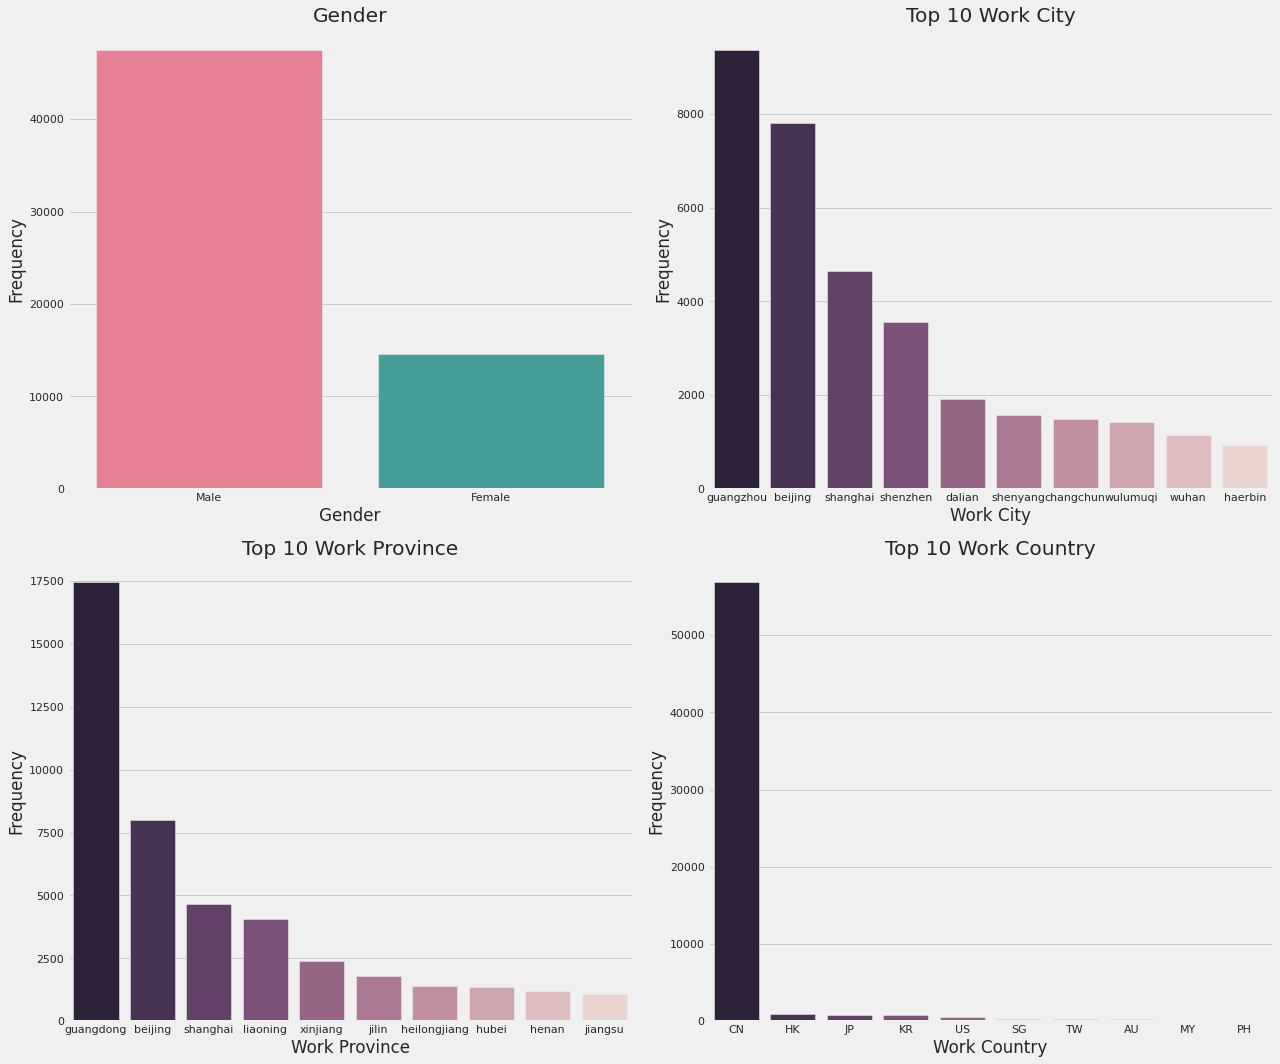

In [14]:
cat_feature = ['GENDER','WORK_CITY','WORK_PROVINCE','WORK_COUNTRY']

f,ax = plt.subplots(2,2,figsize=(18,15))

g = sns.countplot('GENDER',data=df_eda,palette='husl', ax=ax[0,0])
ax[0,0].set_title('Gender')
ax[0,0].set_xlabel('Gender')
ax[0,0].set_ylabel('Frequency')

g = sns.barplot(x='WORK_CITY', y ='FREQ', data=WORK_CITY, ax=ax[0,1], palette=sns.cubehelix_palette(reverse=True, start=0, n_colors=10))
ax[0,1].set_title('Top 10 Work City')
ax[0,1].set_xlabel('Work City')
ax[0,1].set_ylabel('Frequency')

g = sns.barplot(x='WORK_PROVINCE', y ='FREQ', data=WORK_PROVINCE, ax=ax[1,0], palette=sns.cubehelix_palette(reverse=True, start=0, n_colors=10))
ax[1,0].set_title('Top 10 Work Province')
ax[1,0].set_xlabel('Work Province')
ax[1,0].set_ylabel('Frequency')

g = sns.barplot(x='WORK_COUNTRY', y ='FREQ', data=WORK_COUNTRY, ax=ax[1,1], palette=sns.cubehelix_palette(reverse=True, start=0, n_colors=10))
ax[1,1].set_title('Top 10 Work Country')
ax[1,1].set_xlabel('Work Country')
ax[1,1].set_ylabel('Frequency')

plt.tight_layout()

## Univariate Analysis Numeric

In [15]:
numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
display(df_eda.select_dtypes(include=numerics).columns)
print(df_eda.select_dtypes(include=numerics).shape)
data_num = df_eda.select_dtypes(include=numerics)
data_num.head(3)

Index(['MEMBER_NO', 'FFP_TIER', 'AGE', 'FLIGHT_COUNT', 'BP_SUM', 'SUM_YR_1',
       'SUM_YR_2', 'SEG_KM_SUM', 'LAST_TO_END', 'AVG_INTERVAL', 'MAX_INTERVAL',
       'EXCHANGE_COUNT', 'AVG_DISCOUNT', 'Points_Sum', 'Point_NotFlight'],
      dtype='object')

(62044, 15)


,MEMBER_NO,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,AVG_DISCOUNT,Points_Sum,Point_NotFlight
0,54993,6,31.0,210,505308,239560.0,234188.0,580717,1,3.483254,18,34,0.961639,619760,50
1,28065,6,42.0,140,362480,171483.0,167434.0,293678,7,5.194245,17,29,1.252314,415768,33
2,55106,6,40.0,135,351159,163618.0,164982.0,283712,11,5.298507,18,20,1.254676,406361,26


In [16]:
data_num.describe()

,MEMBER_NO,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,AVG_DISCOUNT,Points_Sum,Point_NotFlight
count,62044.000000,62044.000000,61632.000000,62044.000000,62044.000000,62044.000000,62044.000000,62044.000000,62044.000000,62044.000000,62044.000000,62044.000000,62044.000000,62044.000000,62044.000000
mean,31485.237928,4.103652,42.504300,11.971359,11057.772468,5389.298164,5676.826688,17321.694749,172.532703,67.892059,167.189688,0.323480,0.722180,12694.841290,2.754191
std,18188.650537,0.376322,9.885877,14.110619,16424.944888,8123.849287,8736.092628,21052.728111,181.526164,77.393153,123.138316,1.141658,0.184833,20617.694168,7.399359
min,1.000000,4.000000,6.000000,2.000000,0.000000,0.000000,0.000000,368.000000,1.000000,0.000000,0.000000,0.000000,0.136017,0.000000,0.000000
25%,15715.750000,4.000000,35.000000,3.000000,2599.000000,1024.000000,856.000000,4874.000000,29.000000,23.680000,80.000000,0.000000,0.613085,2856.000000,0.000000
50%,31476.500000,4.000000,41.000000,7.000000,5816.000000,2832.000000,2838.000000,10200.000000,105.000000,44.857143,144.000000,0.000000,0.712162,6457.000000,0.000000
75%,47247.250000,4.000000,48.000000,15.000000,13002.250000,6617.000000,6928.000000,21522.500000,260.000000,82.000000,228.000000,0.000000,0.809293,14478.250000,1.000000
max,62988.000000,6.000000,110.000000,213.000000,505308.000000,239560.000000,234188.000000,580717.000000,731.000000,728.000000,728.000000,46.000000,1.500000,985572.000000,140.000000


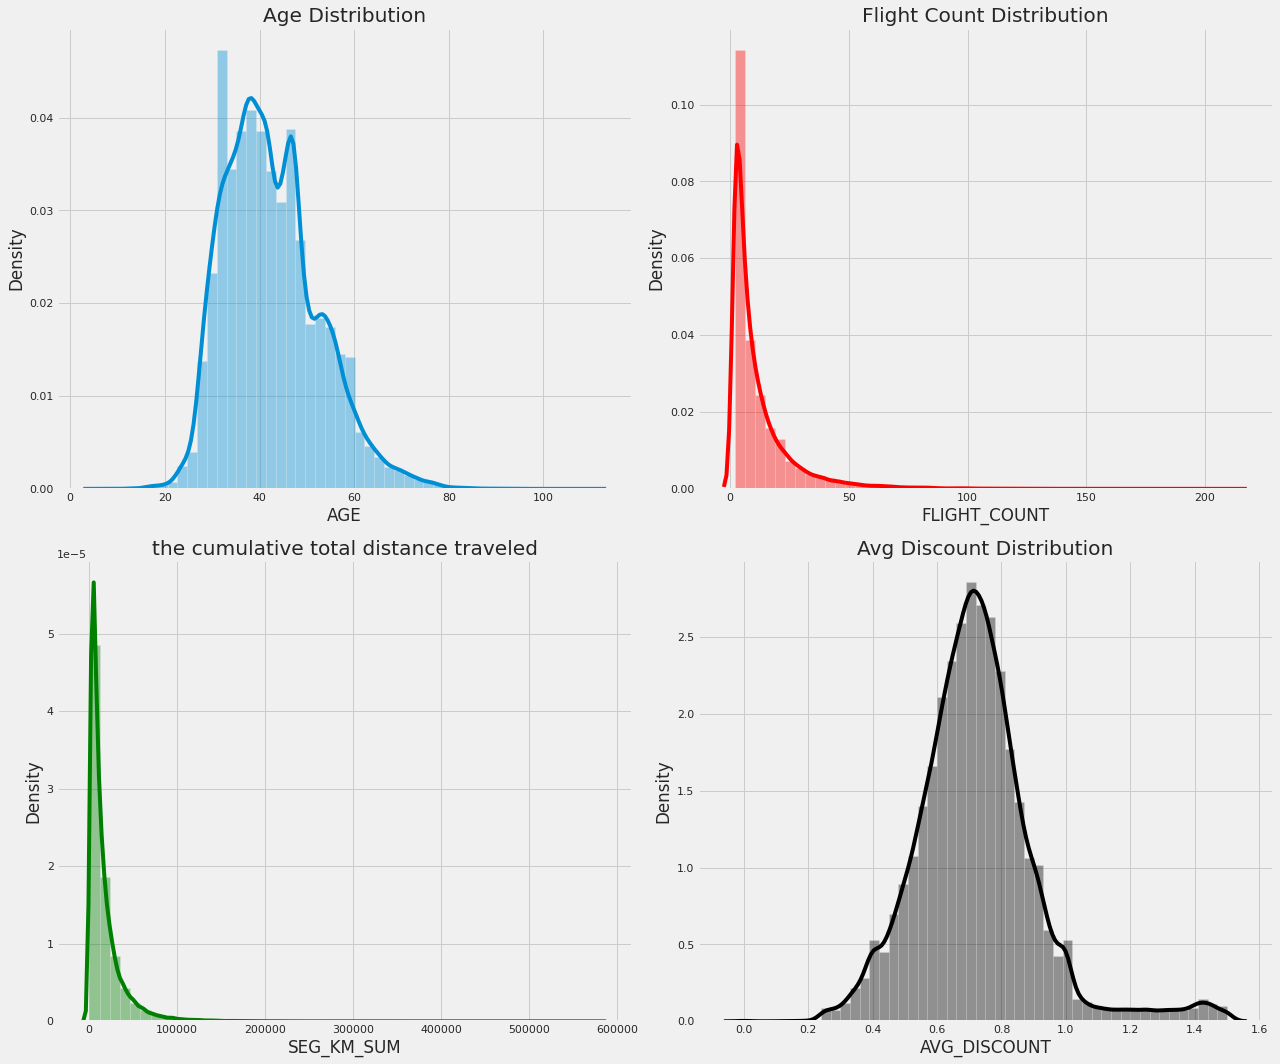

In [17]:
f,ax = plt.subplots(2,2,figsize=(18,15))

g = sns.distplot(data['AGE'], ax=ax[0,0])
ax[0,0].set_title('Age Distribution')

g = sns.distplot(data['FLIGHT_COUNT'], ax=ax[0,1], color='red')
ax[0,1].set_title('Flight Count Distribution')

g = sns.distplot(data['SEG_KM_SUM'], ax=ax[1,0], color='green')
ax[1,0].set_title('the cumulative total distance traveled')

g = sns.distplot(data['AVG_DISCOUNT'], ax=ax[1,1], color='black')
ax[1,1].set_title('Avg Discount Distribution')

plt.tight_layout()

## Multivariate Analysis

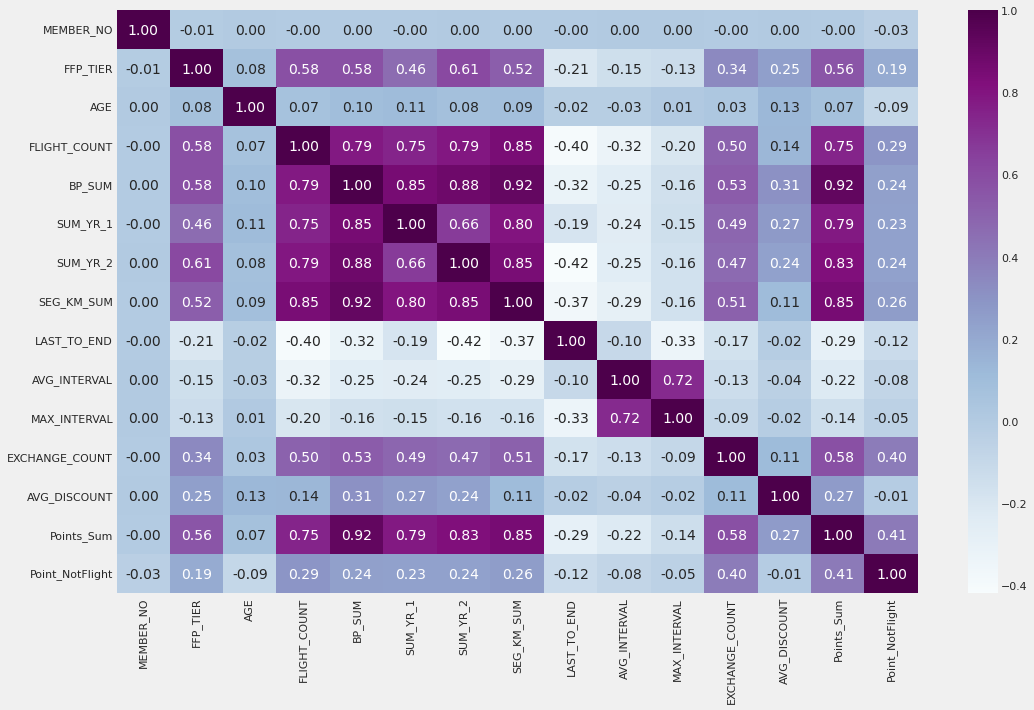

In [18]:
corr_= data_num.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "BuPu")

## Feature Selection

Since we will use the RFM model combined with K-Means clustering algorithm, so for the feature selection we will focus on RFM feature. RFM model (R) current consumption time interval, (F) consumption frequency, (M) total consumption identified.

We do this because there are too many attributes in the original data. According to the airline customer value LRFMC model, we only need to select 6 attributes related to the LRMFC indicator: FFP_DATE, LOAD_TIME, FLIGHT_COUNT, AVG_DISCOUNT, SEG_KM_SUM, LAST_TO_END. 


1. **L (Length Relation)** = LOAD_TIME - FFP_DATE

The number of months since the member ’s membership time from the end of the observation window = end time of the observation window-time to join [unit: month]

2. **R (Recency)** = LAST_TO_END

The number of months since the customer ’s most recent flight to the end of the observation window = the time from the last flight to the end of the observation window [Unit: Month]

3. **F (Frequency)** = FLIGHT_COUNT

The number of times the customer took the company aircraft in the observation window = the number of flights in the observation window [Unit: times]
 
4. **M (Monetary)** = SEG_KM_SUM

The accumulated mileage of the customer in the company during the observation period = the total number of flight kilometers in the observation window [Unit: km]

5. **C (Coefficient)** = AVG_DISCOUNT

The average value of the discount coefficients corresponding to the passengers who traveled during the observation period = average discount rate [Unit: None]



In [82]:
df_LRFMC = df_eda[['LOAD_TIME','FFP_DATE','LAST_TO_END','FLIGHT_COUNT','SEG_KM_SUM','AVG_DISCOUNT']]

In [83]:
df_LRFMC.head()

,LOAD_TIME,FFP_DATE,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM,AVG_DISCOUNT
0,3/31/2014,11/2/2006,1,210,580717,0.961639
1,3/31/2014,2/19/2007,7,140,293678,1.252314
2,3/31/2014,2/1/2007,11,135,283712,1.254676
3,3/31/2014,8/22/2008,97,23,281336,1.090870
4,3/31/2014,4/10/2009,5,152,309928,0.970658


In [85]:
df_LRFMC['L'] = (pd.to_datetime(df_LRFMC['LOAD_TIME']) - pd.to_datetime(df_LRFMC['FFP_DATE'])).dt.days/30 #Calculate the date difference in months
df_LRFMC.rename(columns={'LAST_TO_END':'R','FLIGHT_COUNT':'F','SEG_KM_SUM':'M','AVG_DISCOUNT':'C'},inplace = True)

In [86]:
df_LRFMC = df_LRFMC[['L','R','F','M','C']]

In [87]:
df_LRFMC.head()

,L,R,F,M,C
0,90.200000,1,210,580717,0.961639
1,86.566667,7,140,293678,1.252314
2,87.166667,11,135,283712,1.254676
3,68.233333,97,23,281336,1.090870
4,60.533333,5,152,309928,0.970658


## Duplicate Values

In [88]:
df_LRFMC.duplicated().sum()

84

In [89]:
df_LRFMC=df_LRFMC.drop_duplicates()

## Statistical Summary

In [90]:
df_LRFMC.describe()

,L,R,F,M,C
count,61960.000000,61960.000000,61960.000000,61960.000000,61960.000000
mean,49.659177,172.109716,11.984329,17336.759716,0.722267
std,28.261769,181.161634,14.115741,21061.688443,0.184803
min,12.166667,1.000000,2.000000,368.000000,0.136017
25%,24.566667,29.000000,3.000000,4882.000000,0.613326
50%,42.633333,104.000000,7.000000,10215.500000,0.712329
75%,72.800000,259.000000,15.000000,21539.250000,0.809366
max,114.566667,731.000000,213.000000,580717.000000,1.500000


## Log Transformation

In [91]:
df_LRFMC['L'] = np.log1p(df_LRFMC['L'])
df_LRFMC['R'] = np.log1p(df_LRFMC['R'])
df_LRFMC['F'] = np.log1p(df_LRFMC['F'])
df_LRFMC['M'] = np.log1p(df_LRFMC['M'])
df_LRFMC['C'] = np.log1p(df_LRFMC['C'])

In [93]:
df_LRFMC

,L,R,F,M,C
0,4.513055,0.693147,5.351858,13.272021,0.673780
1,4.472400,2.079442,4.948760,12.590243,0.811958
2,4.479229,2.484907,4.912655,12.555718,0.813006
3,4.237482,4.584967,3.178054,12.547309,0.737580
4,4.119579,1.791759,5.030438,12.644099,0.678367
...,...,...,...,...,...
62039,4.694096,4.499810,1.098612,5.910797,0.536493
62040,4.195195,4.804021,1.098612,5.910797,0.512824
62041,3.837299,3.688879,1.098612,6.968850,0.202941
62042,2.805379,6.142037,1.098612,6.807935,0.223144


## Numeric Distribution and oulier

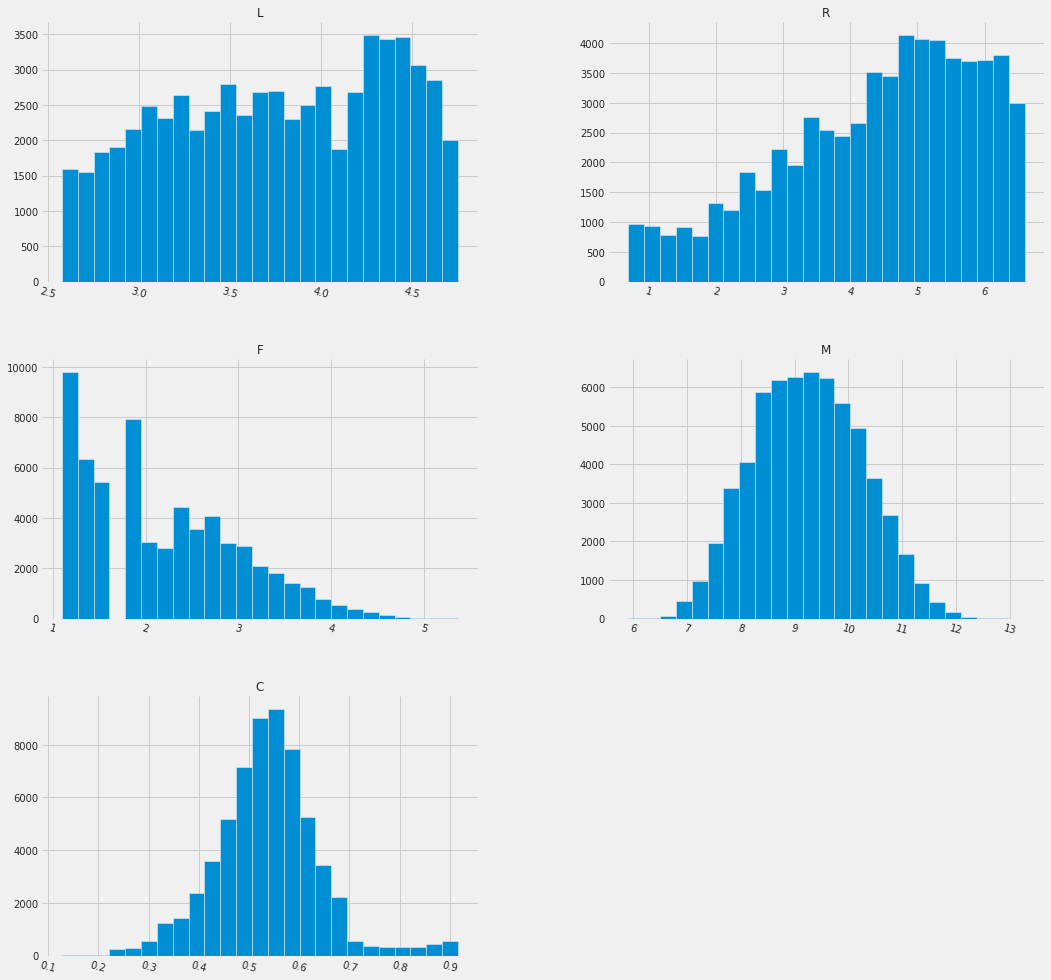

In [29]:
h = df_LRFMC.hist(bins=25,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15)
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

In [94]:
feat_num = list(df_LRFMC)

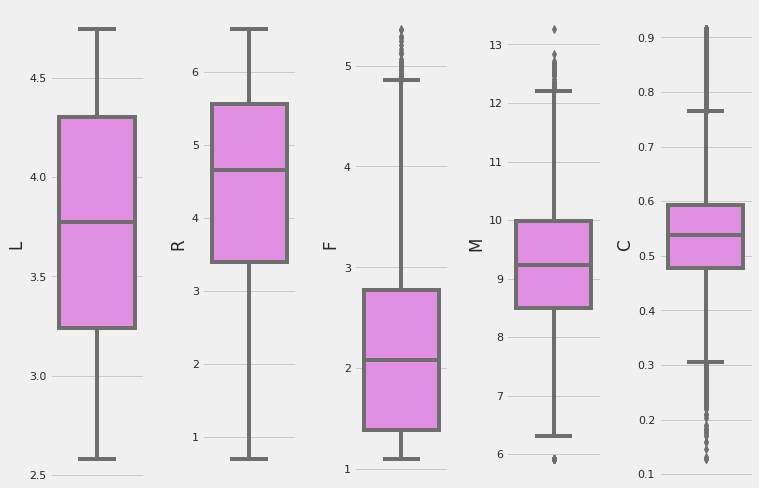

In [95]:
plt.figure(figsize=(15, 7))
for i in range(0, len(feat_num)):
    plt.subplot(1, 7, i+1)
    sns.boxplot(y=df_LRFMC[feat_num[i]],color='violet',orient='v')
    plt.tight_layout()

In [96]:
cols = ['L', 'R', 'F','M','C'] # The columns you want to search for outliers in

# Calculate quantiles and IQR
Q1 = df_LRFMC[cols].quantile(0.25) # Same as np.percentile but maps (0,1) and not (0,100)
Q3 = df_LRFMC[cols].quantile(0.75)
IQR = Q3 - Q1

# Return a boolean array of the rows with (any) non-outlier column values
condition = ~((df_LRFMC[cols] < (Q1 - 1.5 * IQR)) | (df_LRFMC[cols] > (Q3 + 1.5 * IQR))).any(axis=1)

# Filter our dataframe based on condition
df_LRFMC = df_LRFMC[condition]

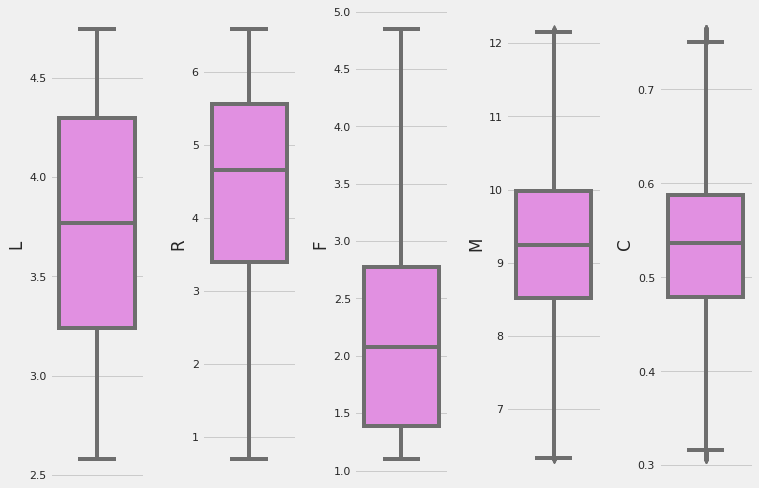

In [97]:
plt.figure(figsize=(15, 7))
for i in range(0, len(feat_num)):
    plt.subplot(1, 7, i+1)
    sns.boxplot(y=df_LRFMC[feat_num[i]],color='violet',orient='v')
    plt.tight_layout()

In [99]:
df_LRFMC.to_csv("df_LRFMC.csv",index=None)

## Scaling

In [100]:
df_LRFMC = pd.read_csv("df_LRFMC.csv")

In [101]:
#Data standardization
sc_df_LRFMC = StandardScaler().fit_transform(df_LRFMC)
df_LRFMC_std=pd.DataFrame(sc_df_LRFMC,columns=list(df_LRFMC))
df_LRFMC_std.head(5)

,L,R,F,M,C
0,1.604899,-0.572139,1.260735,2.897778,2.430347
1,-0.054947,-0.859908,1.105177,2.874778,2.095870
2,-1.105417,-2.533900,3.074686,2.885998,2.016085
3,1.627914,-1.108645,2.242121,2.688033,2.761638
4,0.176348,-1.675253,2.749925,2.881905,1.545716


# Modeling

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

## Find the best K

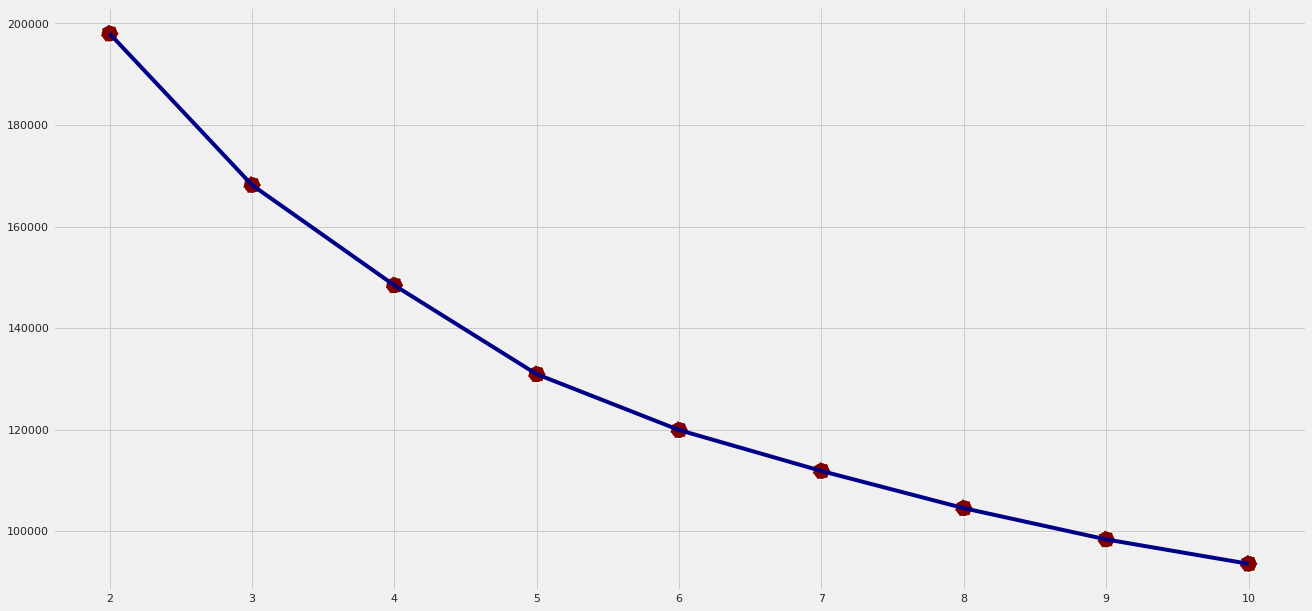

In [102]:
from sklearn.cluster import KMeans
inertia = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=100)
    kmeans.fit(df_LRFMC_std)
    inertia.append(kmeans.inertia_)



plt.figure(figsize=(20, 10))
# plt.plot(inertia)

sns.lineplot(x=range(2, 11), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2, 11), y=inertia, s=300, color='#800000',  linestyle='--')


we will choose, k = 5, and Classifying customers into 5 groups

## Clustering

In [103]:
kmeans = KMeans(n_clusters=5,random_state=100).fit(df_LRFMC_std)

In [104]:
print(kmeans.cluster_centers_)

[[ 0.89456155  0.05151585  0.03553162  0.12117958 -0.05898246]
 [-0.18950366  0.75466639 -0.90333287 -1.00081448  0.87955652]
 [-0.43038993  0.60737519 -0.87604604 -0.78445881 -1.26056701]
 [ 0.58135142 -1.16768648  1.46848018  1.31969449  0.24647858]
 [-0.95301701 -0.32976455  0.35242802  0.41194406  0.02817633]]


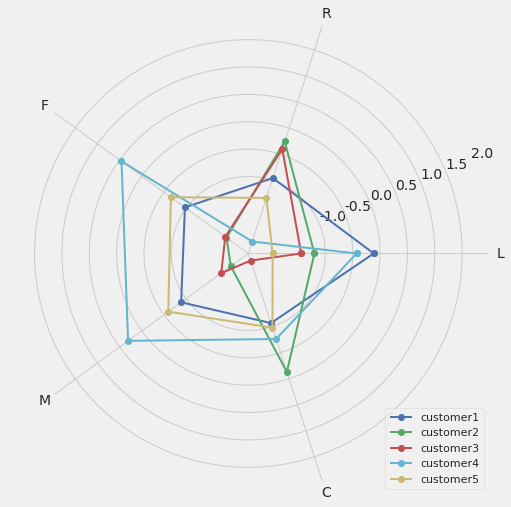

In [121]:
labels = df_LRFMC_std.columns #label
k = 5 #Number of data
plot_data = kmeans.cluster_centers_
color = ['b', 'g', 'r', 'c', 'y'] #Specify the color

angles = np.linspace(0, 2*np.pi, k, endpoint=False)
plot_data = np.concatenate((plot_data, plot_data[:,[0]]), axis=1) # Closed
angles = np.concatenate((angles, [angles[0]])) # Closed

fig = plt.figure()
ax = fig.add_subplot(111, polar=True) #polarparameters! !
for i in range(len(plot_data)):
  ax.plot(angles, plot_data[i], 'o-', color = color[i], label = u'customer'+str(i+1), linewidth=2)# Line drawing

ax.set_rgrids(np.arange(0.01, 3.5, 0.5), np.arange(-1, 2.5, 0.5), fontproperties="SimHei")
ax.set_thetagrids(angles * 180/np.pi, labels, fontproperties="SimHei")
plt.legend(loc = 4)

In [114]:
df_LRFMC_clust = df_LRFMC_std.copy()

In [115]:
df_LRFMC_clust

,L,R,F,M,C
0,1.604899,-0.572139,1.260735,2.897778,2.430347
1,-0.054947,-0.859908,1.105177,2.874778,2.095870
2,-1.105417,-2.533900,3.074686,2.885998,2.016085
3,1.627914,-1.108645,2.242121,2.688033,2.761638
4,0.176348,-1.675253,2.749925,2.881905,1.545716
...,...,...,...,...,...
59055,-0.154473,-0.572139,-1.319376,-2.634737,-1.274262
59056,0.948723,0.715304,-1.319376,-2.913713,-0.081328
59057,0.721422,0.655938,-1.319376,-2.443048,-2.206341
59058,0.193761,1.213924,-1.319376,-2.523475,-2.333468


In [116]:
df_LRFMC_clust['clusters'] = kmeans.labels_

In [117]:
df_LRFMC_clust

,L,R,F,M,C,clusters
0,1.604899,-0.572139,1.260735,2.897778,2.430347,3
1,-0.054947,-0.859908,1.105177,2.874778,2.095870,3
2,-1.105417,-2.533900,3.074686,2.885998,2.016085,3
3,1.627914,-1.108645,2.242121,2.688033,2.761638,3
4,0.176348,-1.675253,2.749925,2.881905,1.545716,3
...,...,...,...,...,...,...
59055,-0.154473,-0.572139,-1.319376,-2.634737,-1.274262,2
59056,0.948723,0.715304,-1.319376,-2.913713,-0.081328,1
59057,0.721422,0.655938,-1.319376,-2.443048,-2.206341,2
59058,0.193761,1.213924,-1.319376,-2.523475,-2.333468,2


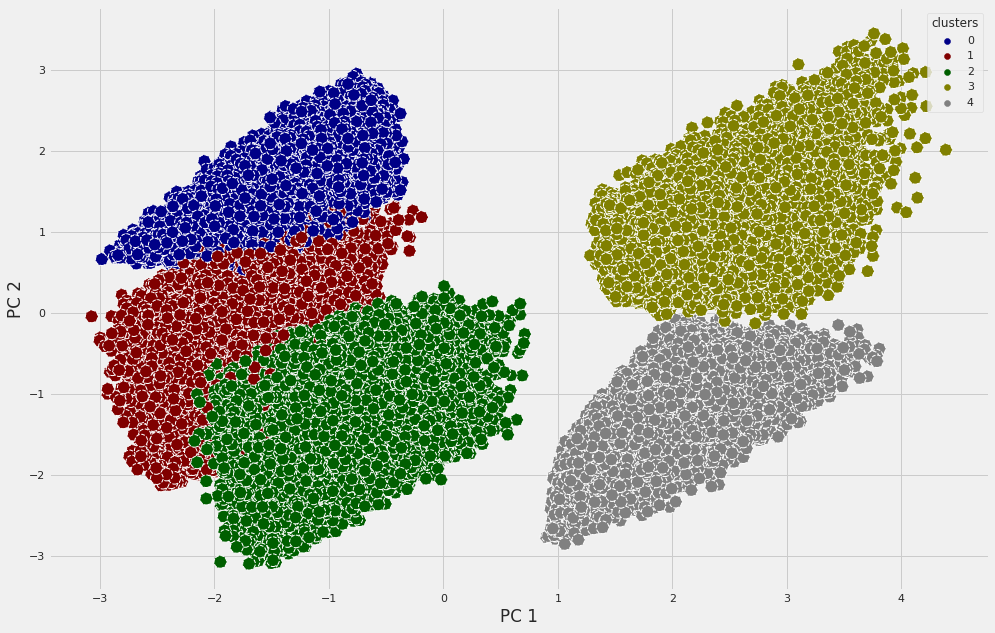

In [118]:
pca = PCA(n_components=2)

pca.fit(df_LRFMC_clust)
pcs = pca.transform(df_LRFMC_clust)

data_pca = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2'])
data_pca['clusters'] = kmeans.labels_

fig, ax = plt.subplots(figsize=(15,10))

sns.scatterplot(
    x="PC 1", y="PC 2",
    hue="clusters",
    edgecolor='white',
    linestyle='--',
    data=data_pca,
    palette=['#000087','#800000','#005f00',"#808000",'#808080'],
    s=160,
    ax=ax
)

In [119]:
clust=df_LRFMC_clust.groupby('clusters').mean()
clust['count']=pd.value_counts(df_LRFMC_clust['clusters'])

In [120]:
clust

,L,R,F,M,C,count
clusters,,,,,,
0,0.894498,0.052431,0.035486,0.120732,-0.056726,13421
1,-0.192319,0.754953,-0.903938,-1.001159,0.878438,12503
2,-0.427666,0.606254,-0.876197,-0.784894,-1.262624,10451
3,0.580478,-1.167648,1.468008,1.319412,0.246383,10755
4,-0.953393,-0.328647,0.351583,0.411550,0.027163,11930


# Insight

#### customer 1

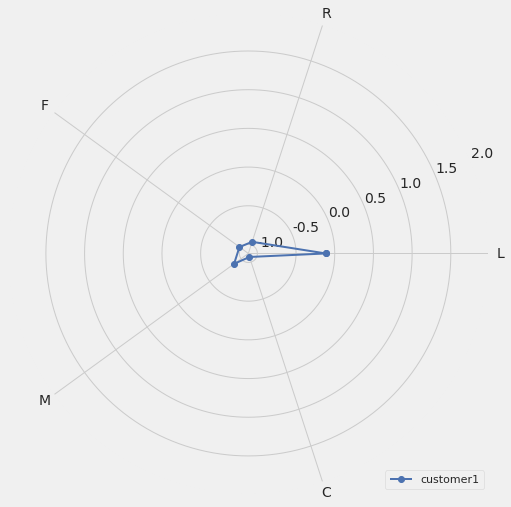

In [128]:
labels = df_LRFMC_std.columns #label
k = 5 #Number of data
plot_data = kmeans.cluster_centers_
color = ['b', 'g', 'r', 'c', 'y'] #Specify the color

angles = np.linspace(0, 2*np.pi, k, endpoint=False)
plot_data = np.concatenate((plot_data, plot_data[:,[0]]), axis=1) # Closed
angles = np.concatenate((angles, [angles[0]])) # Closed

fig = plt.figure()
ax = fig.add_subplot(111, polar=True) #polarparameters! !

ax.plot(angles, plot_data[0], 'o-', color = color[0], label = u'customer'+str(0+1), linewidth=2)# Line drawing

ax.set_rgrids(np.arange(0.01, 3.5, 0.5), np.arange(-1, 2.5, 0.5), fontproperties="SimHei")
ax.set_thetagrids(angles * 180/np.pi, labels, fontproperties="SimHei")
plt.legend(loc = 4)

**customer 1 (13421)**

*   A very high L value indicates that customers in this segment are customers who have been with them for a long time.
*   F and M are relative, indicating a reasonably high frequency and flying distance.
*   A low C suggests that customers in this segment are not very interested in promos and fly not because of promos.



### customer 2

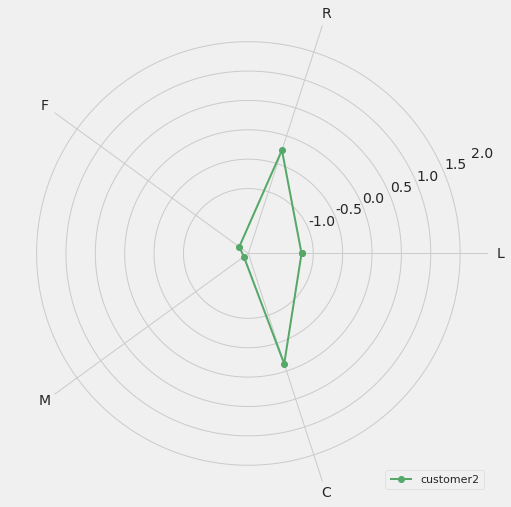

In [123]:
labels = df_LRFMC_std.columns #label
k = 5 #Number of data
plot_data = kmeans.cluster_centers_
color = ['b', 'g', 'r', 'c', 'y'] #Specify the color

angles = np.linspace(0, 2*np.pi, k, endpoint=False)
plot_data = np.concatenate((plot_data, plot_data[:,[0]]), axis=1) # Closed
angles = np.concatenate((angles, [angles[0]])) # Closed

fig = plt.figure()
ax = fig.add_subplot(111, polar=True) #polarparameters! !

ax.plot(angles, plot_data[1], 'o-', color = color[1], label = u'customer'+str(1+1), linewidth=2)# Line drawing

ax.set_rgrids(np.arange(0.01, 3.5, 0.5), np.arange(-1, 2.5, 0.5), fontproperties="SimHei")
ax.set_thetagrids(angles * 180/np.pi, labels, fontproperties="SimHei")
plt.legend(loc = 4)

  
**customer 2 (12503)**

*   R in cluster 2 is the highest R value, which means that customers in this segment have not flown for a long time.
*   The low F and M confirm the statement above because the flight frequency and mileage are the lowest.
*   If we look at C or average discount, we can see that customers in this segment are customers who fly because of discounts/promotions.


### customer 3

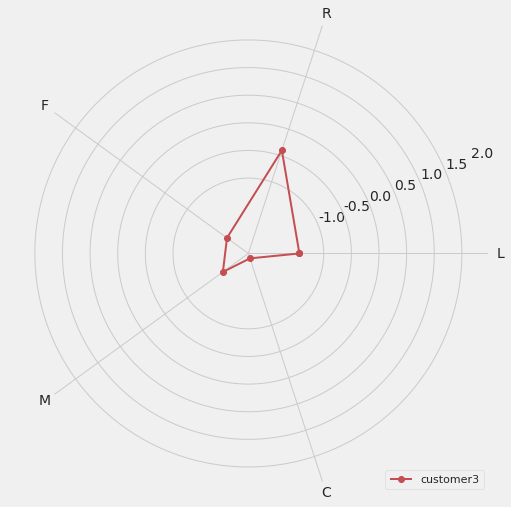

In [125]:
labels = df_LRFMC_std.columns #label
k = 5 #Number of data
plot_data = kmeans.cluster_centers_
color = ['b', 'g', 'r', 'c', 'y'] #Specify the color

angles = np.linspace(0, 2*np.pi, k, endpoint=False)
plot_data = np.concatenate((plot_data, plot_data[:,[0]]), axis=1) # Closed
angles = np.concatenate((angles, [angles[0]])) # Closed

fig = plt.figure()
ax = fig.add_subplot(111, polar=True) #polarparameters! !

ax.plot(angles, plot_data[2], 'o-', color = color[2], label = u'customer'+str(2+1), linewidth=2)# Line drawing

ax.set_rgrids(np.arange(0.01, 3.5, 0.5), np.arange(-1, 2.5, 0.5), fontproperties="SimHei")
ax.set_thetagrids(angles * 180/np.pi, labels, fontproperties="SimHei")
plt.legend(loc = 4)

**customer 3 (10451)**

*   The low L value indicates that the customer in this segment is new.

*   A very low C value indicates that customers in this segment are not customers who fly because of the promo.
*   Low F and M indicate that customers in this segment do not fly often.



### customer 4

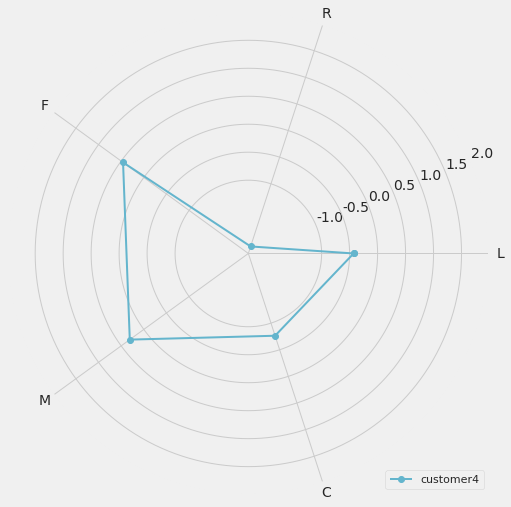

In [126]:
labels = df_LRFMC_std.columns #label
k = 5 #Number of data
plot_data = kmeans.cluster_centers_
color = ['b', 'g', 'r', 'c', 'y'] #Specify the color

angles = np.linspace(0, 2*np.pi, k, endpoint=False)
plot_data = np.concatenate((plot_data, plot_data[:,[0]]), axis=1) # Closed
angles = np.concatenate((angles, [angles[0]])) # Closed

fig = plt.figure()
ax = fig.add_subplot(111, polar=True) #polarparameters! !

ax.plot(angles, plot_data[3], 'o-', color = color[3], label = u'customer'+str(3+1), linewidth=2)# Line drawing

ax.set_rgrids(np.arange(0.01, 3.5, 0.5), np.arange(-1, 2.5, 0.5), fontproperties="SimHei")
ax.set_thetagrids(angles * 180/np.pi, labels, fontproperties="SimHei")
plt.legend(loc = 4)

**customer 4 (10755)**


*   In this segment, F and M are the highest. The flight frequency and customer mileage in this segment are the highest.
*   If we look at L, L in this segment is the second-largest L, which means that customers in this segment are customers who have been registered for a long time.
*   A low R value indicates that customers in this segment further strengthen the high Frequency and Monetary.



### customer 5

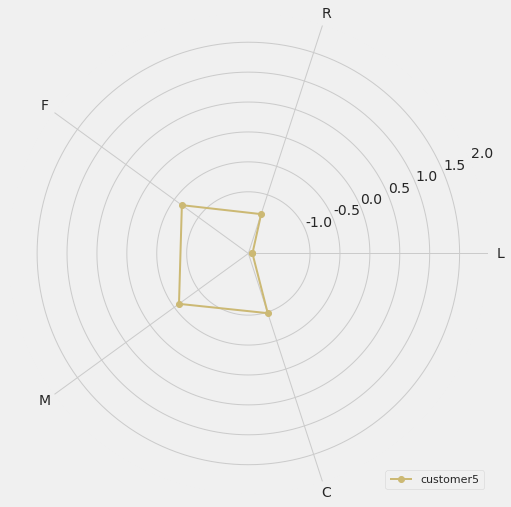

In [127]:
labels = df_LRFMC_std.columns #label
k = 5 #Number of data
plot_data = kmeans.cluster_centers_
color = ['b', 'g', 'r', 'c', 'y'] #Specify the color

angles = np.linspace(0, 2*np.pi, k, endpoint=False)
plot_data = np.concatenate((plot_data, plot_data[:,[0]]), axis=1) # Closed
angles = np.concatenate((angles, [angles[0]])) # Closed

fig = plt.figure()
ax = fig.add_subplot(111, polar=True) #polarparameters! !

ax.plot(angles, plot_data[4], 'o-', color = color[4], label = u'customer'+str(4+1), linewidth=2)# Line drawing

ax.set_rgrids(np.arange(0.01, 3.5, 0.5), np.arange(-1, 2.5, 0.5), fontproperties="SimHei")
ax.set_thetagrids(angles * 180/np.pi, labels, fontproperties="SimHei")
plt.legend(loc = 4)

**customer 5 (11930)**
*   A high C value illustrates that customers in this segment are interested because of the promo.
*   And a very low L value, meaning that the customers in this segment are new.
*   F and M indicate that customers in this segment have a reasonably frequent flight frequency.